### Basic data checks

I started by inspecting the dataset and checking for missing values or duplicated entries.

In [30]:
import pandas as pd

df = pd.read_csv('Time_Series.csv')

print('data shape:', df.shape)
print(df.head(3))
# df.describe().T

data shape: (2103, 322)
   Date             0             1             2             3             4  \
0     0  1.296695e+10  1.457547e+10  1.325288e+09 -2.655211e+10  2.101698e+10   
1     1  1.296838e+10  1.457465e+10  1.328991e+09 -2.655095e+10  2.115096e+10   
2     2  1.305118e+10  1.463240e+10  1.306612e+09 -2.651588e+10  2.114048e+10   

              5             6             7             8  ...           311  \
0 -9.094024e+09  4.858148e+09 -2.356104e+09 -3.233936e+10  ... -1.644660e+10   
1 -9.086957e+09  4.913736e+09 -2.354550e+09 -3.234193e+10  ... -1.773644e+10   
2 -9.094517e+09  4.919696e+09 -2.304025e+09 -3.232356e+10  ... -1.761549e+10   

            312           313           314           315           316  \
0  9.440106e+09  1.541441e+10  1.119134e+10  4.934779e+09 -1.751067e+09   
1  9.416437e+09  1.545443e+10  1.118869e+10  4.936015e+09 -1.749437e+09   
2  9.425556e+09  1.552926e+10  1.119478e+10  4.963428e+09 -1.776820e+09   

            317           318

In [31]:
# Check for missing values
print(df.isnull().sum().sum(), "total missing values")

# Check for duplicates
dup_cols = df.T.duplicated().sum()
dup_rows = df.duplicated().sum()

print(f"Duplicate columns: {dup_cols}")
print(f"Duplicate rows: {dup_rows}")

0 total missing values
Duplicate columns: 0
Duplicate rows: 0


The dataset contains no missing values and no duplicated rows, so it can be used directly for modeling.

### Trading volume over time

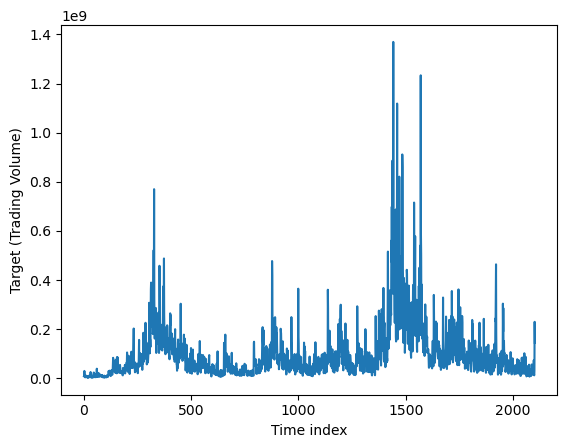

In [32]:
import matplotlib.pyplot as plt
target_col = df.columns[-1]
target = df[target_col]

plt.figure()
plt.plot(target.values)
plt.xlabel("Time index")
plt.ylabel("Target (Trading Volume)")
plt.show()

The figure below shows the trading volume over time.
The series exhibits large spikes and periods of high volatility, which suggests that the scale of the target variable changes substantially over time.

### Distribution of the target variable

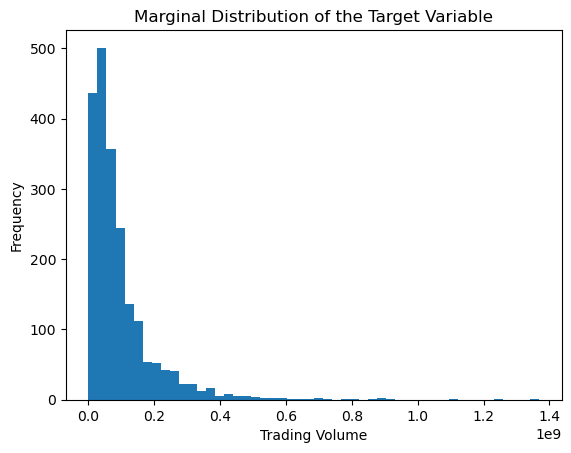

In [ ]:
plt.figure()
plt.hist(target, bins=50)
plt.xlabel("Trading Volume")
plt.ylabel("Frequency")
plt.title("Marginal Distribution of the Target Variable")
plt.show()

The marginal distribution of the target variable is strongly right-skewed.
Most observations are concentrated at relatively low values, while a small number of extreme spikes dominate the upper tail. This kind of skewed distribution can make training unstable, because a few extreme values dominate the loss.

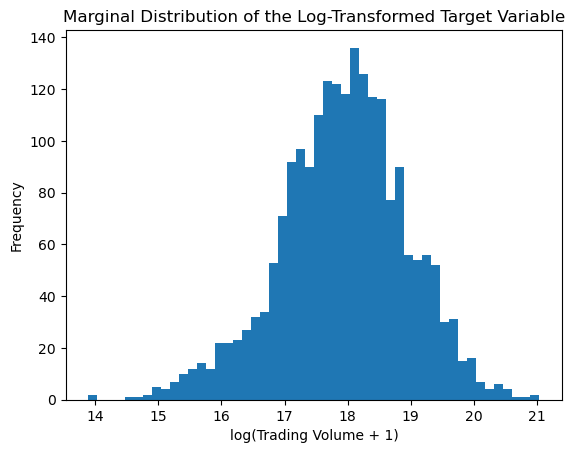

In [ ]:
import numpy as np

log_target = np.log1p(df[target_col])

plt.figure()
plt.hist(log_target, bins=50)
plt.xlabel("log(Trading Volume + 1)")
plt.ylabel("Frequency")
plt.title("Marginal Distribution of the Log-Transformed Target Variable")
plt.show()

To reduce the impact of extreme values, I applied a $log(1 + y)$ transformation to the target variable.
After the transformation, the distribution becomes much more symmetric and closer to a bell shape, which is generally easier for neural models to learn.

### Autocorrelation analysis (ACF and PACF)

<Figure size 640x480 with 0 Axes>

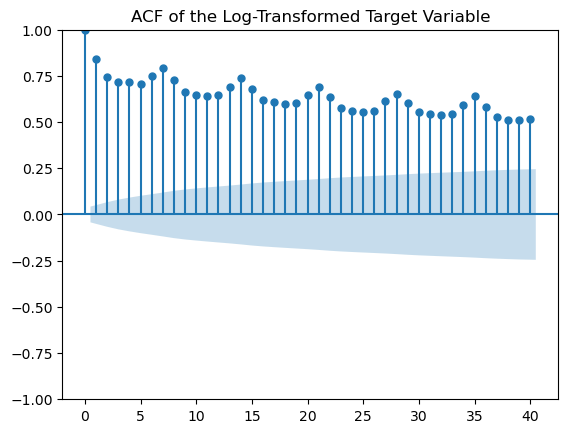

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure()
plot_acf(log_target, lags=40)
plt.title("ACF of the Log-Transformed Target Variable")
plt.show()

The ACF shows strong positive correlation across many lags.
Instead of dropping quickly, the correlations decay slowly, which indicates strong persistence in the series.
This suggests that recent trading volume levels are highly informative about the next time step.

<Figure size 640x480 with 0 Axes>

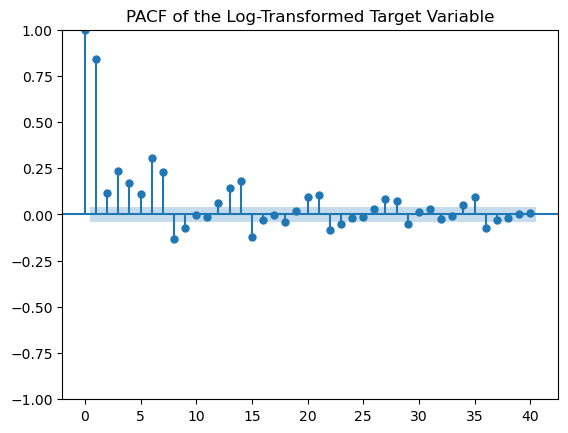

In [ ]:
plt.figure()
plot_pacf(log_target, lags=40, method="ywm")
plt.title("PACF of the Log-Transformed Target Variable")
plt.show()

The PACF shows that the strongest direct dependency occurs at the first few lags, especially at lag 1.
After that, the partial correlations drop off quickly.
This indicates that most of the direct predictive signal comes from very recent observations.

Taken together, the ACF and PACF suggest that the series is **strongly autoregressive**, with the most important information coming from recent values.
This also implies that a simple persistence forecast, where the next value is predicted as the current one, could already be a strong baseline.
